In [1]:
import numpy as np

###############################################################################
##Defining the necessities
#Defining (n, k)
num_channels = 2
num_messages = 4
num_bits = 2
################################################################################
##Generating the training data, one hot vectors of width num_messages
num_samples = 10000
training_data = np.zeros([num_samples, num_messages])

file = open("training_data-a.npy", 'wb')
file1 = open("training_data-b.npy", 'wb')

for iter in range(num_samples):

    training_data[iter, np.random.randint(num_messages)] = 1
np.save(file, training_data)
print(training_data)

training_data = np.zeros([num_samples, num_messages])

for iter in range(num_samples):
    training_data[iter, np.random.randint(num_messages)] = 1

np.save(file1, training_data)
print(training_data)
file.close()
file1.close()
###############################################################################
##Generating the test data, one hot vectors of width num_messages
num_samples = 5000
test_data = np.zeros([num_samples, num_messages])

file = open("test_data-a.npy", 'wb')
file1 = open("test_data-b.npy", 'wb')

for iter in range(num_samples):
    test_data[iter, np.random.randint(num_messages)] = 1

np.save(file, test_data)
print(test_data)

test_data = np.zeros([num_samples, num_messages])

for iter in range(num_samples):
    test_data[iter, np.random.randint(num_messages)] = 1

np.save(file1, test_data)

file.close()
file1.close()


[[1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 ...
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]]
[[0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 ...
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]]
[[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 ...
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]]


In [2]:
file_train = open("training_data-a.npy", "rb")
file_train1 = open("training_data-b.npy", "rb")
file_test = open("test_data-a.npy", "rb")
file_test1 = open("test_data-b.npy", "rb")

training_data_a = np.load(file_train)
test_data_a = np.load(file_test)
training_data_b = np.load(file_train1)
test_data_b = np.load(file_test1)

training_data = np.concatenate((training_data_a, training_data_b), axis = 1)
test_data  = np.concatenate((test_data_a, test_data_b), axis = 1)

file_train.close()
file_test.close()
file_train1.close()
file_test1.close()

print(training_data)
print(test_data.shape)

[[1. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [1. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 1. 0.]]
(5000, 8)


In [3]:
import keras
from keras.layers import Input, Dense
from keras.optimizers import SGD, Adam
from keras.models import Model
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import tensorflow as tf

Using TensorFlow backend.


In [71]:
learning_rate = 0.1
msg_len = 4
input_dim = 2*msg_len
channel_num = 2
encoding_dim = 2*channel_num
midlayer_dim = int((msg_len+channel_num)/2)+1
print ("midlayer_dim :", midlayer_dim )
energy_per_bit1 = 5
energy_per_bit2 = 5

midlayer_dim : 4


In [72]:
input_msg1 = Input(shape = (msg_len, ))
print("Input shape : ", input_dim)
input_msg2 = Input(shape = (msg_len, ))


lambda_l1_1 = keras.layers.Lambda(lambda x : x)(input_msg1)
encoded_l1_1 = Dense(msg_len, activation = 'relu')(lambda_l1_1)
encoded_l1_2 = Dense(channel_num, activation = 'linear')(encoded_l1_1)
encoded_l1_3 = keras.layers.BatchNormalization(axis=1)(encoded_l1_2)

lambda_l2_1 = keras.layers.Lambda(lambda x : x)(input_msg2)
encoded_l2_1 = Dense(msg_len, activation = 'relu')(lambda_l2_1)
encoded_l2_2 = Dense(channel_num, activation = 'linear')(encoded_l2_1)
encoded_l2_3 = keras.layers.BatchNormalization(axis=1)(encoded_l2_2)

added_layer = keras.layers.Add()([encoded_l1_3, encoded_l2_3])
encoded_l1_4 = keras.layers.GaussianNoise(np.sqrt(channel_num/(2*msg_len*energy_per_bit1)))(added_layer)
encoded_l2_4 = keras.layers.GaussianNoise(np.sqrt(channel_num/(2*msg_len*energy_per_bit2)))(added_layer)

decoded_l1_1 = Dense(midlayer_dim, activation = 'relu')(encoded_l1_4)
decoded_l2_1 = Dense(midlayer_dim, activation = 'relu')(encoded_l2_4)

decoded_l1_2 = Dense(midlayer_dim, activation = 'softmax')(decoded_l1_1)
decoded_l2_2 = Dense(midlayer_dim, activation = 'softmax')(decoded_l2_1)

# concat_layer = keras.layers.concatenate([decoded_l1_2, decoded_l2_2], axis = 1)

# decoded_out = Dense(input_dim)(concat_layer)


Input shape :  8


In [73]:
sgd = SGD(learning_rate)
autoencoder = Model([input_msg1, input_msg2], [decoded_l1_2, decoded_l2_2])
autoencoder.compile(optimizer = sgd, loss='mean_squared_error')

In [74]:
encoder1 = Model(input_msg1, encoded_l1_3)
encoder2 = Model(input_msg2, encoded_l2_3)

In [75]:
print(training_data_a.shape)
# print(keras.backend.shape(decoded_out))
print(autoencoder.summary())
# list_of_arrays = []
# list_of_arrays.append(np.ndarray(training_data_a))
# list_of_arrays.append(np.ndarray(training_data_b))
# print(list_of_arrays)
autoencoder.fit(x = [training_data_a, training_data_b],y = [training_data_a, training_data_b], epochs=100, batch_size=50, shuffle=True,validation_data=([test_data_a, test_data_b], [test_data_a, test_data_b]))

(10000, 4)
Model: "model_32"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           (None, 4)            0                                            
__________________________________________________________________________________________________
input_15 (InputLayer)           (None, 4)            0                                            
__________________________________________________________________________________________________
lambda_15 (Lambda)              (None, 4)            0           input_14[0][0]                   
__________________________________________________________________________________________________
lambda_16 (Lambda)              (None, 4)            0           input_15[0][0]                   
________________________________________________________________________________

Epoch 21/100
10000/10000 [==============================] - 0s 48us/step - loss: 0.0163 - dense_67_loss: 0.0073 - dense_68_loss: 0.0090 - val_loss: 0.0020 - val_dense_67_loss: 0.0011 - val_dense_68_loss: 9.0217e-04
Epoch 22/100
10000/10000 [==============================] - 0s 50us/step - loss: 0.0171 - dense_67_loss: 0.0082 - dense_68_loss: 0.0090 - val_loss: 0.0031 - val_dense_67_loss: 0.0021 - val_dense_68_loss: 9.6484e-04
Epoch 23/100
10000/10000 [==============================] - 1s 56us/step - loss: 0.0144 - dense_67_loss: 0.0073 - dense_68_loss: 0.0071 - val_loss: 0.0029 - val_dense_67_loss: 9.4860e-04 - val_dense_68_loss: 0.0019
Epoch 24/100
10000/10000 [==============================] - 0s 47us/step - loss: 0.0151 - dense_67_loss: 0.0082 - dense_68_loss: 0.0069 - val_loss: 0.0018 - val_dense_67_loss: 8.4257e-04 - val_dense_68_loss: 9.5716e-04
Epoch 25/100
10000/10000 [==============================] - 1s 58us/step - loss: 0.0126 - dense_67_loss: 0.0054 - dense_68_loss: 0.0072 

10000/10000 [==============================] - 1s 52us/step - loss: 0.0093 - dense_67_loss: 0.0030 - dense_68_loss: 0.0063 - val_loss: 6.0880e-04 - val_dense_67_loss: 4.1573e-04 - val_dense_68_loss: 1.9307e-04
Epoch 59/100
10000/10000 [==============================] - 0s 45us/step - loss: 0.0077 - dense_67_loss: 0.0043 - dense_68_loss: 0.0033 - val_loss: 3.6176e-04 - val_dense_67_loss: 1.7487e-04 - val_dense_68_loss: 1.8689e-04
Epoch 60/100
10000/10000 [==============================] - 1s 56us/step - loss: 0.0074 - dense_67_loss: 0.0033 - dense_68_loss: 0.0041 - val_loss: 2.7517e-04 - val_dense_67_loss: 1.7243e-04 - val_dense_68_loss: 1.0273e-04
Epoch 61/100
10000/10000 [==============================] - 1s 52us/step - loss: 0.0047 - dense_67_loss: 0.0019 - dense_68_loss: 0.0029 - val_loss: 2.8035e-04 - val_dense_67_loss: 1.6775e-04 - val_dense_68_loss: 1.1260e-04
Epoch 62/100
10000/10000 [==============================] - 1s 56us/step - loss: 0.0103 - dense_67_loss: 0.0064 - dense_6

Epoch 95/100
10000/10000 [==============================] - 0s 44us/step - loss: 0.0036 - dense_67_loss: 0.0017 - dense_68_loss: 0.0019 - val_loss: 1.3834e-04 - val_dense_67_loss: 8.7447e-05 - val_dense_68_loss: 5.0894e-05
Epoch 96/100
10000/10000 [==============================] - 0s 47us/step - loss: 0.0019 - dense_67_loss: 7.8851e-04 - dense_68_loss: 0.0011 - val_loss: 1.2873e-04 - val_dense_67_loss: 8.8005e-05 - val_dense_68_loss: 4.0728e-05
Epoch 97/100
10000/10000 [==============================] - 1s 52us/step - loss: 0.0065 - dense_67_loss: 0.0032 - dense_68_loss: 0.0033 - val_loss: 1.3162e-04 - val_dense_67_loss: 9.1585e-05 - val_dense_68_loss: 4.0031e-05
Epoch 98/100
10000/10000 [==============================] - 0s 47us/step - loss: 0.0057 - dense_67_loss: 0.0021 - dense_68_loss: 0.0036 - val_loss: 1.8001e-04 - val_dense_67_loss: 9.2968e-05 - val_dense_68_loss: 8.7041e-05
Epoch 99/100
10000/10000 [==============================] - 1s 53us/step - loss: 0.0068 - dense_67_loss:

(5000, 2)


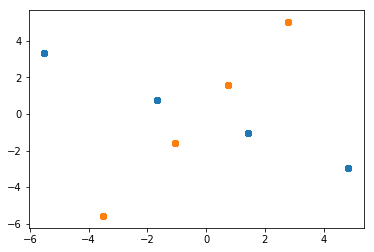

In [76]:
pred1 = encoder1.predict(test_data_a)
pred2 = encoder2.predict(test_data_b)

print(pred1.shape)

plt.scatter(pred1[:, 0], pred1[:, 1])
plt.scatter(pred2[:, 0], pred2[:, 1])
plt.show()